After initializing the model and performing the forward and backward passes, we often face a problem: the model's performance is initially poor. To improve this, we perform Parameter Optimization. Since the parameters (weights and biases) are the primary variables we can adjust during training, our goal is to iteratively update them to find the values that minimize the loss function.

In our time, there is a huge number of optimizers, but we will explore only a little part of them:
- Gradient Descent
- Stochastic gradient descent
- Momentum
- Adam

---

**Gradient descent**

This is the most popular and fundamental method which works the following way:

>
>Step 1: Compute the gradient of the loss with respect to the parameters
>$$\frac{\partial L}{\partial \phi} = \begin{bmatrix} \frac{\partial L}{\partial \phi_0} \\ \frac{\partial L}>{\partial \phi_1} \\ \vdots \\ \frac{\partial L}{\partial \phi_N} \end{bmatrix}.$$
>This vector points uphill, in the direction of increasing loss.
>
>Step 2: Update the parameters by moving a small step downhill
>$$\phi \gets \phi - \alpha \frac{\partial L}{\partial \phi},$$
>where $\alpha > 0$ is the learning rate, controlling the step size.
>- If $\alpha$ is too small, convergence is slow.
>- If $\alpha$ is too large, we may overshoot the minimum.
>
>We may either fix $\alpha$ or perform a line search to find the value that most decreases the loss at each >step.
>
>At the minimum of the loss function, the gradient is zero $\left(\frac{\partial L}{\partial \phi} = >0\right)$, so the parameters stop changing. In practice, we monitor the gradient magnitude and stop when >it is small enough.

<div align="center">
<img src="./images/Pasted image 20251114084917.png" width="400" />
</div>

In [15]:
import numpy as np
from typing import Dict

In [16]:
# we start with a base class

class Optimizer:
  def __init__(self):
    pass
    
  def update(self, 
             params: Dict[str, np.ndarray], 
             grads: Dict[str, np.ndarray], 
             learning_rate: float):
    return NotImplementedError("Subclasses must implement 'update'")

In [17]:
class GradientDescent(Optimizer):    
  def update(self, params, grads, learning_rate):
    
    for key in params:
      
      grad_key = f"dL_{key}"
      
      if grad_key in grads:
        params[key] -= learning_rate * grads[grad_key]

---

**Stochastic gradient descent**

Gradient descent is not bad method, but - it imageine we have 1 million parameters. For each of them - we need to compute backpropagation - it takes a huge time. More clever would be to use a batch of them. This apporach not only solves the time complexity problem, but also helps to escape local minima.

*So, how actually SGD works?*

Stochastic gradient descent SGD addresses this limitation by adding randomness to the gradient at each step.
- The updates still move downhill on average, but at any given iteration, the direction might not be the steepest descent.
- Sometimes the algorithm may move uphill, temporarily increasing the loss.
- This randomness allows the algorithm to jump from one “valley” to another, helping it escape local minima

Below is the algorithm:

>- At each iteration, a random subset of the training data—called a minibatch or batch — is selected.
>- The gradient is computed only for the examples in this batch, not the full dataset.
>
>The update rule for the parameters $\phi_t$ at iteration $t$ is:
>$$\phi_{t+1} \gets \phi_t - \alpha \sum_{i \in B_t} \frac{\partial \ell_i[\phi_t]}{\partial \phi},$$
>where:
>- $B_t$ is the set of indices in the current batch
>- $\ell_i$ is the loss for the $i$-th example
>- $\alpha$ is the learning rate, controlling the step size
>
>The learning rate is fixed at the start and does not depend on the local gradient. Training proceeds through >all examples in the dataset without replacement.
>- One pass through the full dataset is called an epoch.
>- A batch may range from a single example to the whole dataset.
>- If the batch contains the entire dataset, we recover full-batch (regular) gradient descent.


The class for SGD will be not implemented since we can automatically swtich to SGD using `batch_size` in method `train`

-----

**Momentum**

Okay, we solve time complexity problem and escaping local minima with SGD. So, why we need some others apporachs?

If we look at path of SGD(a), we can see that it is quite random and not smooth:
<div align="center"\>
<img src="./images/Pasted image 20251114101255.png" width="400" /\>
</div>


So, how to make it smooth? We add some concept - "momentum"

> The easiest way to understand momentum is to think about a heavy ball rolling down a hilly landscape (the loss surface).
>
>   - **Standard SGD:** Imagine a very light, 'sticky' ball. At every step, you calculate the slope (gradient) *exactly* where it is, and then move it in that direction.
>
>     $$W = W - \alpha \cdot dW$$
>     *(Where $\alpha$ is learning rate, $dW$ is the gradient)*
>
>     If it's in a narrow valley or "ravine," the slope of one batch might point to the left wall, and the next batch's slope might point to the right wall. The ball will oscillate back and forth, making very slow progress *down* the valley.
>
>   - **SGD with Momentum:** Now, imagine a heavy bowling ball.
>
>     1.  It has **inertia** (or momentum). It "remembers" the direction it was already rolling ($v_{t-1}$).
>     2.  The new gradient (from the current batch) gives it a small "push" ($dW$).
>     3.  Its final movement is a combination of its *existing momentum* and the *new push*.
>
>     We calculate a **velocity** term $v$ before updating the weights:
>
>     $$v_{t} = \beta v_{t-1} + (1 - \beta) dW$$
>     $$W = W - \alpha v_{t}$$
>
>       * $\beta$ (Beta): Friction/Decay rate (usually 0.9). Controls how much "memory" of the past we keep.
>       * $v_{t-1}$: The previous velocity (Inertia).
>       * $dW$: The current gradient (The Push).

**Why is this better?**

  - **It smooths out the path (image above, b):** The heavy ball isn't bothered by small, noisy "pushes" from individual batches. It averages them out, leading to a much **smoother trajectory**.
  - **It escapes ravines (reduces oscillation):** In that narrow valley, the "push left" from one batch and "push right" from the next batch will *cancel each other out* over time. The only direction that is *consistent* is "down the valley." The ball's momentum builds up in this one consistent direction, and it speeds down the valley floor instead of oscillating between the walls.

In [18]:
class Momentum(Optimizer):
  def __init__(self, beta: float = 0.9):
    self.beta = beta
    self.velocities = {}
    
    if(self.beta > 1 or self.beta < 0):
      raise ValueError("Beta`s value must be in range from 0 to 1")
    
  def update(self, params, grads, learning_rate):
    for key in params:
      grad_key = f"dL_d{key}"
      
      old_velocity = self.velocities.get(key, 0)
      
      if grad_key in grads:
        new_velocity = self.beta * old_velocity + (1 - self.beta) * grads[grad_key]
        params[key] -= learning_rate * new_velocity
        self.velocities[key] = new_velocity

**Adam**

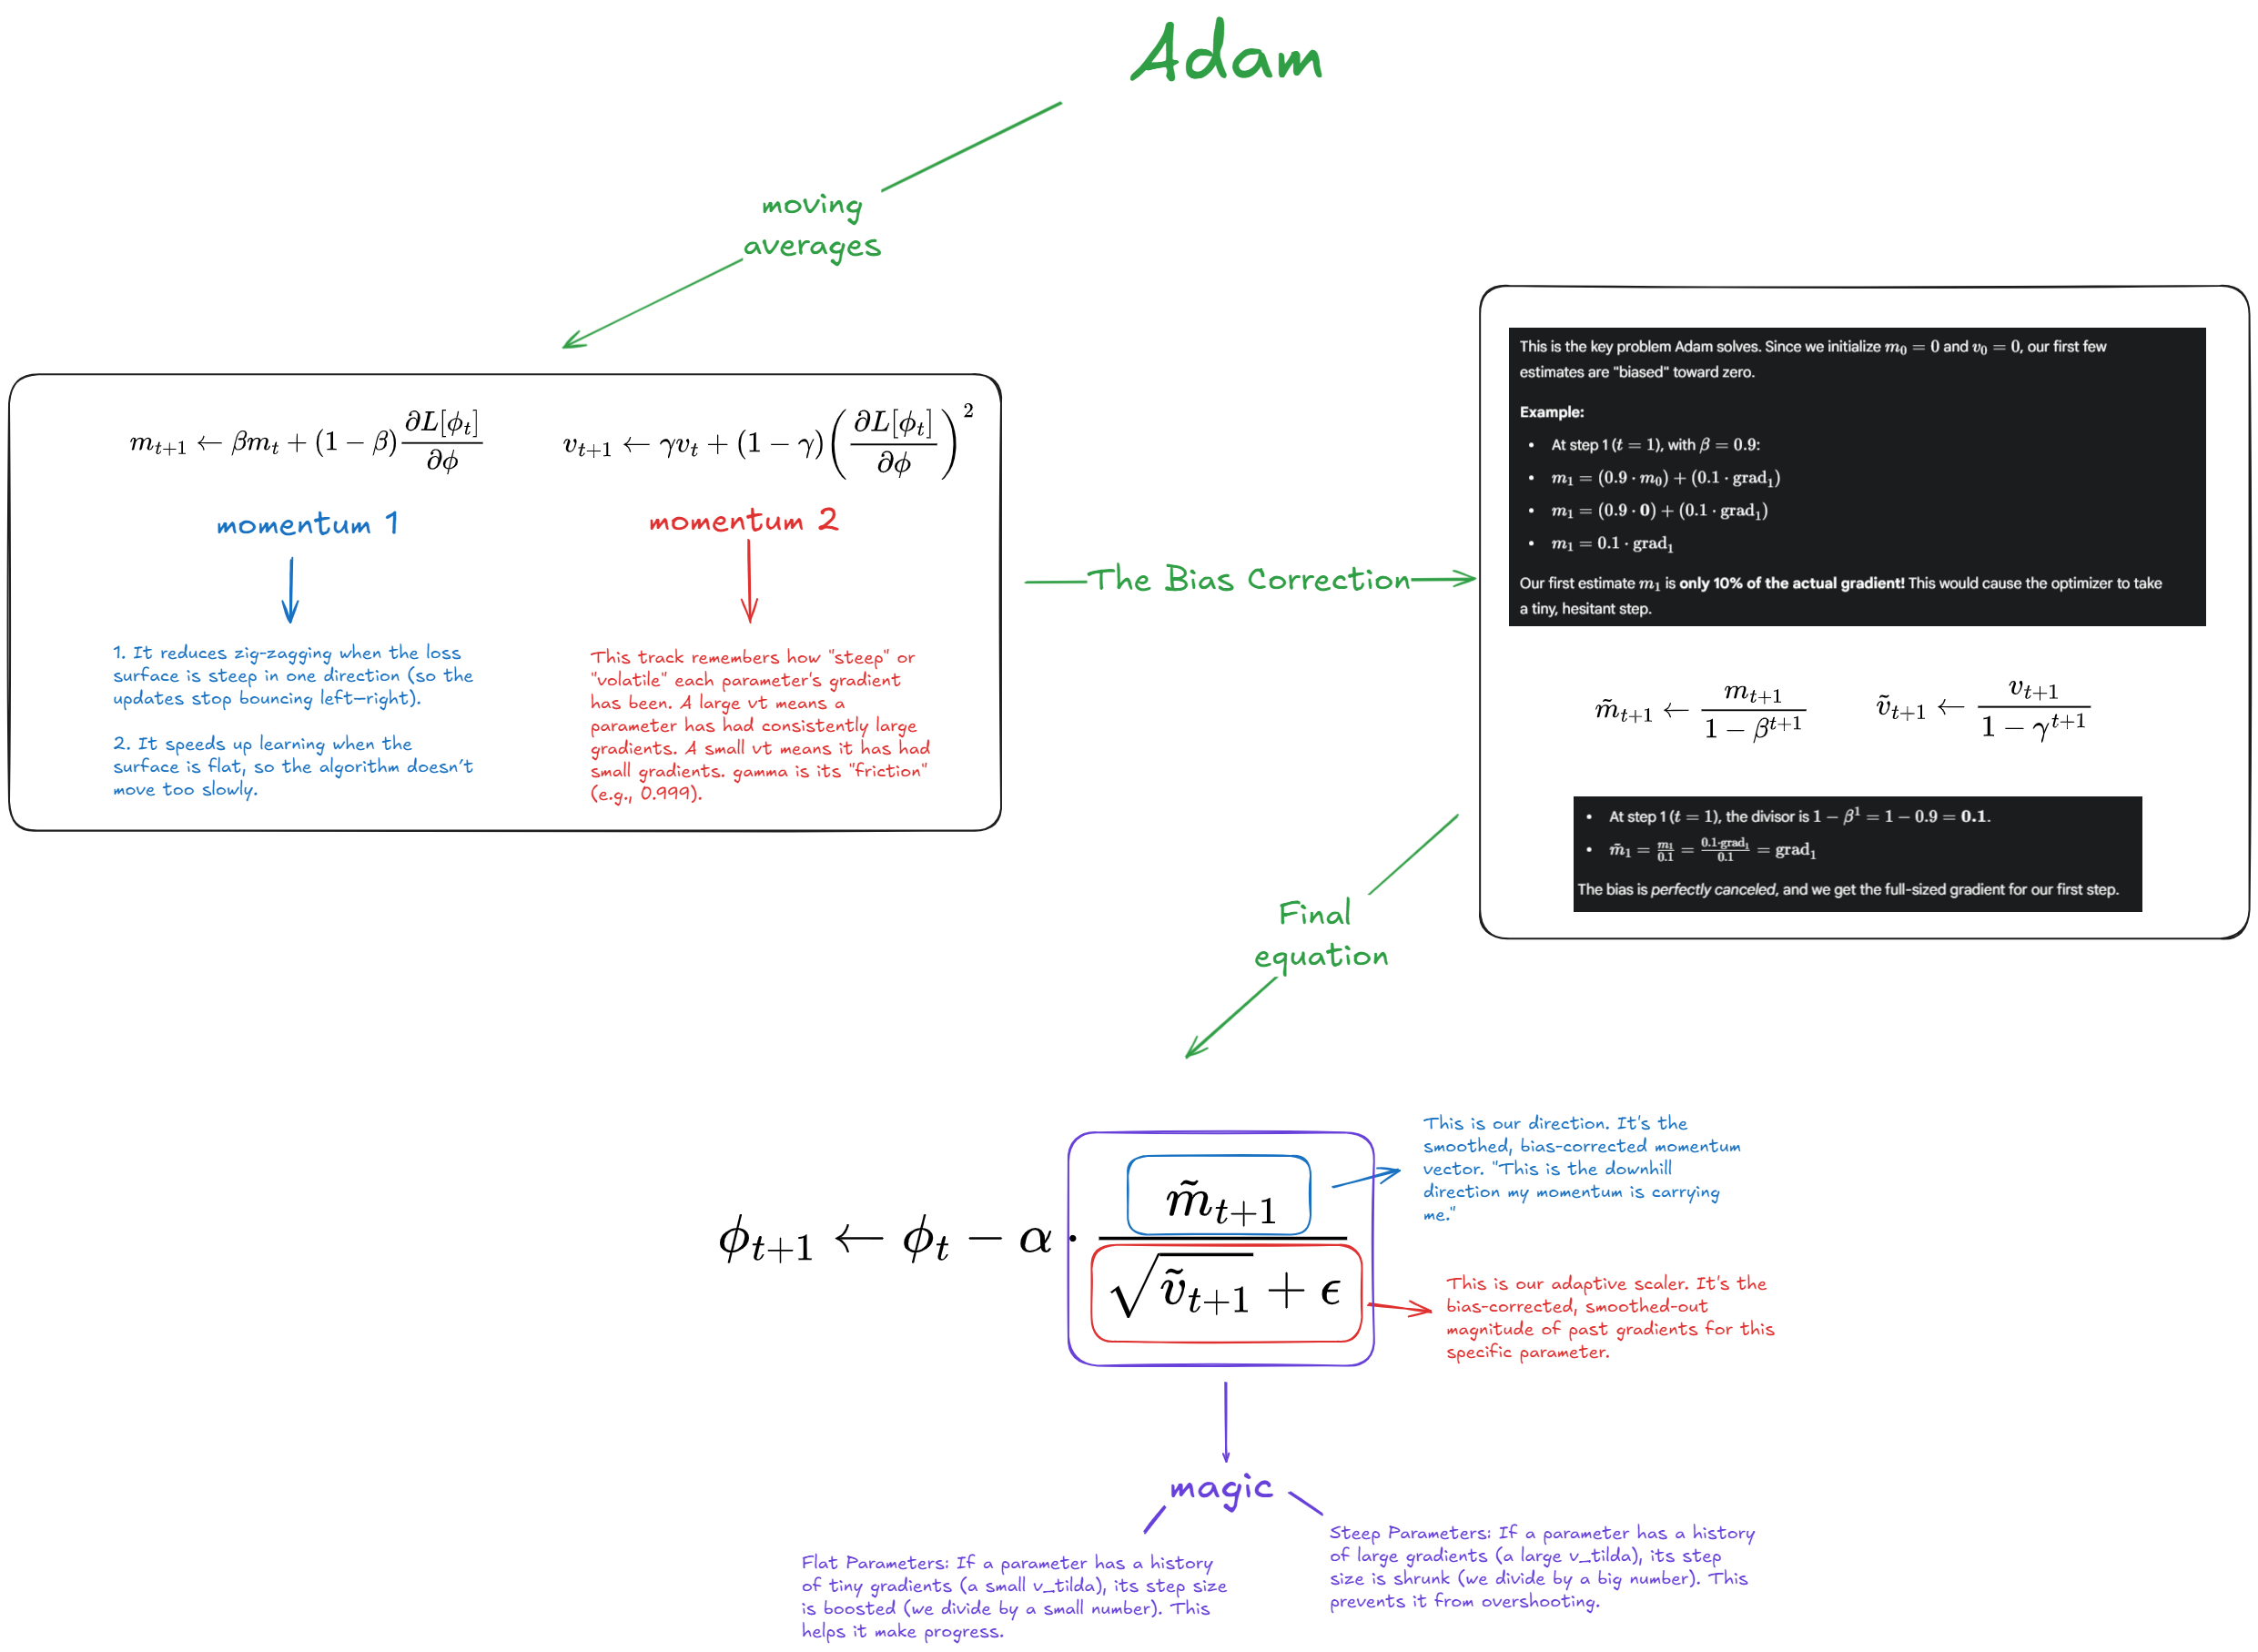

From picture above we can understad that Adam has two important features:
1.  **Momentum + Adaptive Scaling (RMSProp):**
    * **Momentum ($m_t$ - First Moment):** Like the heavy ball, it tracks the *direction* (average of past gradients). It smooths out the zig-zags.
    * **Adaptive Scaler ($v_t$ - Second Moment):** It tracks the *magnitude* (average of squared gradients). If gradients are huge and noisy, it divides by a large number to slow down (shrink). If gradients are tiny and flat, it divides by a small number to speed up (boost).

2.  **Bias Correction ("No Warm-up"):**
    * Since $m$ and $v$ are initialized to **zeros**, the first few steps would be heavily biased towards zero (the ball wouldn't move).
    * Bias correction (dividing by $1 - \beta^t$) artificially boosts the values in the first few steps so the algorithm starts working effectively immediately, without needing a "warm-up" period to build momentum.


In [19]:
class Adam(Optimizer):
  def __init__(self, beta = 0.9, hamma = 0.999, epsilon = 1e-8):
    self.beta = beta
    self.hamma = hamma
    self.t = 0
    self.epsilon = epsilon
    
    if(self.beta < 0 or self.beta > 1):
      raise ValueError("Parameter beta must be in range from 0 to 1")
    if(self.hamma < 0 or self.hamma > 1):
      raise ValueError("Parameter hamma must be in range from 0 to 1")
    
    self.m = {}
    self.v = {}
    
  def update(self, params, grads, learning_rate): 
    
    self.t += 1
     
    for key in params:
      old_momentum = self.m.get(key, 0)
      old_velocity = self.v.get(key, 0)
      grad_key = f"dL_d{key}"
      
      if grad_key in grads:
        new_momentum = self.beta * old_momentum + (1 - self.beta) * grads[grad_key]
        new_velocity = self.hamma * old_velocity + (1 - self.hamma) * np.power(grads[grad_key], 2)
        
        #bias correction
        new_momentum_hat = new_momentum / (1 - np.power(self.beta, self.t))
        new_velocity_hat = new_velocity / (1 - np.power(self.hamma, self.t))
        
        params[key] -= learning_rate * (new_momentum_hat / (np.sqrt(new_velocity_hat) + self.epsilon))
        
        self.m[key] = new_momentum
        self.v[key] = new_velocity